In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from QuestradeAPI import QuestradeAPI, Chronos
from autogluon.timeseries import TimeSeriesDataFrame
from autogluon.timeseries.models import DeepARModel
import plotly.express as px

# Initialize components
api = QuestradeAPI()  # Handles authentication automatically
chronos = Chronos(api=api)  # Data caching and persistence layer


# 1. Data Collection Phase

In [ ]:
# Define the symbols we want to analyze
symbols = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "TSLA", "NVDA"]
interval = "OneMinute"  # Using daily data for better forecasting results
days_history = 365  # Get one year of historical data

# Function to collect data for all symbols
def collect_market_data(symbols, interval="OneMinute", days=365, force_refresh=False):
    """
    Collects market data for multiple symbols and stores it in the Chronos database
    """
    print(f"Collecting {interval} data for {len(symbols)} symbols...")
    
    for i, symbol in enumerate(symbols):
        print(f"Processing {symbol} ({i+1}/{len(symbols)})...")
        # This will automatically cache the data in the SQLite database
        data = chronos.get_candles(
            symbol=symbol, 
            interval=interval, 
            days=days,
            force_refresh=force_refresh
        )
        print(f"  Retrieved {len(data)} candles")
    
    print("Data collection complete!")

# Collect the data (uncomment if you need to refresh the data)
#collect_market_data(symbols, interval=interval, days=days_history)


Processing AAPL (1/7)...
Symbol AAPL found in cache
Using cached data for AAPL with interval OneMinute
Retrieved 42134 candles for AAPL
  Retrieved 42134 candles
Processing MSFT (2/7)...
Symbol MSFT found in cache
Using cached data for MSFT with interval OneMinute
Retrieved 35298 candles for MSFT
  Retrieved 35298 candles
Processing GOOGL (3/7)...
Symbol GOOGL found in cache
Using cached data for GOOGL with interval OneMinute
Retrieved 38684 candles for GOOGL
  Retrieved 38684 candles
Processing AMZN (4/7)...
Symbol AMZN found in cache
Using cached data for AMZN with interval OneMinute
Retrieved 42067 candles for AMZN
  Retrieved 42067 candles
Processing META (5/7)...
Symbol META found in cache
Using cached data for META with interval OneMinute
Retrieved 34785 candles for META
  Retrieved 34785 candles
Processing TSLA (6/7)...
Symbol TSLA found in cache
Using cached data for TSLA with interval OneMinute
Retrieved 53436 candles for TSLA
  Retrieved 53436 candles
Processing NVDA (7/7)...

# 2. Data Preparation Phase

In [43]:
# Retrieve all market data from the database
print("Retrieving all market data from database...")
all_market_data = chronos.get_all_market_data()


Retrieving all market data from database...
Database file not found at C:\Users\yaloo\QuestradeCustomWrapper\data\market_data.db


In [44]:
# Check data types to ensure compatibility with TimeSeriesDataFrame
print("\nData Types:")
print(all_market_data.dtypes)


Data Types:
Series([], dtype: object)


In [31]:
# Basic data exploration
print(f"\nDataset shape: {all_market_data.shape}")
print(f"Number of unique symbols: {all_market_data['symbol'].nunique()}")
print(f"Date range: {all_market_data['start'].min()} to {all_market_data['start'].max()}")



Dataset shape: (301998, 10)
Number of unique symbols: 7
Date range: 2024-12-23 05:00:00 to 2025-03-22 00:00:00


In [32]:
# Show sample data
print("\nSample data:")
display(all_market_data.head())



Sample data:


,symbol,start,end,low,high,open,close,volume,VWAP,interval
0,AAPL,2024-12-23 05:00:00,2024-12-24 05:00:00,253.45,255.65,254.77,255.27,40858774,254.713964,OneDay
1,AAPL,2024-12-23 09:28:00,2024-12-23 09:29:00,255.59,255.59,255.59,255.59,232,255.577901,OneMinute
2,AAPL,2024-12-23 09:30:00,2024-12-23 09:31:00,255.49,255.61,255.54,255.61,400,255.554710,OneMinute
3,AAPL,2024-12-23 09:34:00,2024-12-23 09:35:00,255.52,255.57,255.57,255.52,810,255.559809,OneMinute
4,AAPL,2024-12-23 09:37:00,2024-12-23 09:38:00,255.63,255.63,255.63,255.63,270,255.569315,OneMinute


# 3. Data Preprocessing for AutoGluon

Ensure timestamp columns are properly formatted.This is critical because AutoGluon requires timestamp without timezone info

In [33]:
print("\nFormatting timestamp columns...")

# Verify timestamp column format
if 'start' in all_market_data.columns:
    # Convert to datetime if not already
    all_market_data['start'] = pd.to_datetime(all_market_data['start'], utc=True)
    # Remove timezone information 
    all_market_data['start'] = all_market_data['start'].dt.tz_localize(None)
    print(f"Timestamp format: {all_market_data['start'].dtype}")

# Filter to just the symbols we want to analyze
filtered_data = all_market_data[all_market_data['symbol'].isin(symbols)]



Formatting timestamp columns...
Timestamp format: datetime64[ns]


# 4. Create TimeSeriesDataFrame for AutoGluon


Creating TimeSeriesDataFrame for AutoGluon...
TimeSeriesDataFrame created with shape: (301998, 8)
Number of unique time series: 7


end     low    high    open  \
item_id timestamp                                                         
AAPL    2024-12-23 05:00:00 2024-12-24 05:00:00  253.45  255.65  254.77   
        2024-12-23 09:28:00 2024-12-23 09:29:00  255.59  255.59  255.59   
        2024-12-23 09:30:00 2024-12-23 09:31:00  255.49  255.61  255.54   
        2024-12-23 09:34:00 2024-12-23 09:35:00  255.52  255.57  255.57   
        2024-12-23 09:37:00 2024-12-23 09:38:00  255.63  255.63  255.63   

                              close    volume        VWAP   interval  
item_id timestamp                                                     
AAPL    2024-12-23 05:00:00  255.27  40858774  254.713964     OneDay  
        2024-12-23 09:28:00  255.59       232  255.577901  OneMinute  
        2024-12-23 09:30:00  255.61       400  255.554710  OneMinute  
        2024-12-23 09:34:00  255.52       810  255.559809  OneMinute  
        2024-12-23 09:37:00  255.63       270  255.569315  OneMinute


Visualizing stock prices over time...


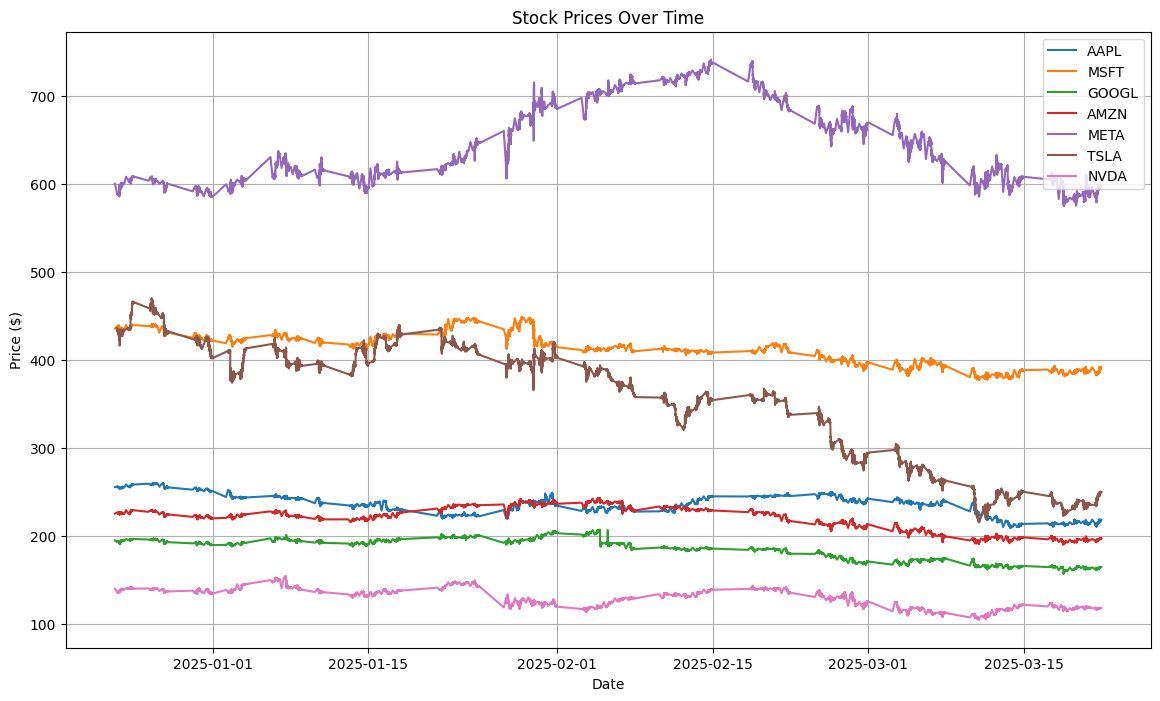

In [34]:
print("\nCreating TimeSeriesDataFrame for AutoGluon...")
ts_data = TimeSeriesDataFrame.from_data_frame(
    filtered_data,
    id_column="symbol",
    timestamp_column="start"
)

print(f"TimeSeriesDataFrame created with shape: {ts_data.shape}")
print(f"Number of unique time series: {ts_data.num_items}")
display(ts_data.head())

# 5. Visualize the data
print("\nVisualizing stock prices over time...")
plt.figure(figsize=(14, 8))

# Plot each symbol's closing price
for symbol in symbols:
    symbol_data = filtered_data[filtered_data['symbol'] == symbol]
    plt.plot(symbol_data['start'], symbol_data['close'], label=symbol)

plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# 6. Prepare data for forecasting

In [35]:
# Split data into train and test sets
# Use the last 5 days as test data
# The index is a MultiIndex with (item_id, timestamp), so we need to get the max timestamp differently
max_timestamp = ts_data.index.get_level_values('timestamp').max()
split_date = max_timestamp - pd.Timedelta(days=5)

# Filter based on the timestamp level of the index
train_data = ts_data[ts_data.index.get_level_values('timestamp') <= split_date]
test_data = ts_data[ts_data.index.get_level_values('timestamp') > split_date]

print(f"Train data shape: {train_data.shape}, from {train_data.index.get_level_values('timestamp').min()} to {train_data.index.get_level_values('timestamp').max()}")
print(f"Test data shape: {test_data.shape}, from {test_data.index.get_level_values('timestamp').min()} to {test_data.index.get_level_values('timestamp').max()}")


Train data shape: (277524, 8), from 2024-12-23 05:00:00 to 2025-03-14 23:59:00
Test data shape: (24474, 8), from 2025-03-17 04:00:00 to 2025-03-22 00:00:00


In [37]:
# 1. Investigate and address the high NaN percentage
def analyze_missing_values(ts_data):
    """Analyze patterns of missing values in the time series data"""
    print("Analyzing missing value patterns...")
    
    # Check missing values by symbol
    for item_id in ts_data.item_ids:
        series = ts_data.loc[item_id]
        total = len(series)
        missing = series['close'].isna().sum()
        print(f"Symbol {item_id}: {missing}/{total} missing values ({missing/total*100:.2f}%)")
        
        # Check for patterns in missing values (e.g., weekends)
        if missing > 0:
            # Get timestamps with missing values
            missing_times = series[series['close'].isna()].index
            # Check day of week
            day_counts = missing_times.day_name().value_counts()
            print(f"  Missing by day of week: {day_counts}")
            # Check hour of day
            hour_counts = missing_times.hour.value_counts()
            print(f"  Missing by hour: {hour_counts}")

# Run this analysis on your data
analyze_missing_values(ts_data)

# 2. Fill missing values more intelligently based on the patterns
def fill_missing_values(ts_data, method='forward'):
    """Fill missing values with more appropriate methods"""
    filled_data = ts_data.copy()
    
    for item_id in filled_data.item_ids:
        # Get the item's data
        item_data = filled_data.loc[item_id]
        
        # Fill missing values
        if method == 'forward':
            # Forward fill (use previous value)
            filled_data.loc[item_id] = item_data.fillna(method='ffill')
        elif method == 'interpolate':
            # Interpolate linearly between points
            filled_data.loc[item_id] = item_data.interpolate(method='linear')
        elif method == 'trading_hours':
            # Only fill during trading hours (9:30 AM to 4:00 PM Eastern Time)
            # First convert index to Eastern Time
            eastern_idx = item_data.index.tz_localize('UTC').tz_convert('US/Eastern')
            trading_mask = (eastern_idx.hour >= 9) & (eastern_idx.hour < 16)
            trading_mask = trading_mask | ((eastern_idx.hour == 9) & (eastern_idx.minute >= 30))
            
            # Only fill during trading hours
            trading_data = item_data.copy()
            trading_data.loc[~trading_mask] = np.nan  # Set non-trading times to NaN
            filled_data.loc[item_id] = trading_data.fillna(method='ffill')
    
    return filled_data

# 3. Create a more appropriate training dataset
# First, fill missing values with an appropriate method
filled_ts_data = fill_missing_values(ts_data, method='trading_hours')

# Then filter to just trading hours to reduce dataset size and focus on relevant times
def filter_trading_hours(ts_data):
    """Filter data to just include trading hours"""
    filtered_data = {}
    
    for item_id in ts_data.item_ids:
        # Get the item's data
        item_data = ts_data.loc[item_id]
        
        # Convert index to Eastern Time
        eastern_idx = item_data.index.tz_localize('UTC').tz_convert('US/Eastern')
        
        # Create mask for trading hours (9:30 AM to 4:00 PM Eastern Time)
        trading_mask = (eastern_idx.hour >= 9) & (eastern_idx.hour < 16)
        trading_mask = trading_mask | ((eastern_idx.hour == 9) & (eastern_idx.minute >= 30))
        
        # Filter to just trading hours
        filtered_data[item_id] = item_data.loc[trading_mask]
    
    # Convert back to TimeSeriesDataFrame
    return TimeSeriesDataFrame.from_dict(filtered_data, freq="min")

# Filter to just trading hours
trading_ts_data = filter_trading_hours(filled_ts_data)
print(f"Filtered data shape: {trading_ts_data.shape}")
print(f"NaN percentage in filtered data: {trading_ts_data.isna().sum().sum() / trading_ts_data.size * 100:.2f}%")

# 4. Use a validation strategy better suited for financial time series
# The last 5 days (trading week) is often a good validation period
def create_financial_train_val_split(ts_data, val_days=5):
    """Create train/validation split with the last val_days as validation"""
    train_data = {}
    val_data = {}
    
    # Calculate cutoff time (5 trading days ≈ 1950 minutes)
    minutes_per_day = 390  # 6.5 hours * 60 minutes
    val_minutes = val_days * minutes_per_day
    
    for item_id in ts_data.item_ids:
        series = ts_data.loc[item_id]
        if len(series) > val_minutes:
            train_data[item_id] = series.iloc[:-val_minutes]
            val_data[item_id] = series.iloc[-val_minutes:]
        else:
            # If not enough data, use half for training
            mid_point = len(series) // 2
            train_data[item_id] = series.iloc[:mid_point]
            val_data[item_id] = series.iloc[mid_point:]
    
    # Convert to TimeSeriesDataFrame
    return (
        TimeSeriesDataFrame.from_dict(train_data, freq="min"),
        TimeSeriesDataFrame.from_dict(val_data, freq="min")
    )

# Create better train/validation split
train_ts, val_ts = create_financial_train_val_split(trading_ts_data, val_days=5)
print(f"Training data: {train_ts.shape}, Validation data: {val_ts.shape}")

# 5. Retrain with more appropriate settings for financial time series
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    target=target,
    eval_metric='MAPE',  # MAPE is good for financial data
    freq="min",
    path="models/stock_predictor_improved",
    verbosity=2
)

# Train with better settings
predictor.fit(
    train_data=train_ts,
    tuning_data=val_ts,  # Explicit validation data
    time_limit=600,  # 10 minutes
    presets="medium_quality_faster_train",  # Better quality than 'fast_training'
    hyperparameters={
        # Configure models that work well for high-frequency financial data
        'RecursiveTabular': {  # Already performing well
            'estimator': 'lightgbm',  # Use LightGBM for better performance
            'lag_features': True,     # Enable lag features
            'num_samples': 100        # More samples for better predictions
        },
        'DirectTabular': {  # Also likely to perform well based on initial results
            'estimator': 'lightgbm',
            'lag_features': True,
            'num_samples': 100
        },
        'DeepAR': {  # Deep learning approach
            'context_length': 60,     # More context for minute data (1 hour)
            'hidden_size': 64,        # Smaller size due to time constraint
            'num_layers': 2,
            'epochs': 10              # Limit epochs due to time constraint
        }
    }
)

Analyzing missing value patterns...
Symbol AAPL: 0/42194 missing values (0.00%)
Symbol AMZN: 0/42127 missing values (0.00%)
Symbol GOOGL: 0/38744 missing values (0.00%)
Symbol META: 0/34845 missing values (0.00%)
Symbol MSFT: 0/35358 missing values (0.00%)
Symbol NVDA: 0/55294 missing values (0.00%)
Symbol TSLA: 0/53436 missing values (0.00%)


C:\Users\yaloo\AppData\Local\Temp\ipykernel_9512\1228674342.py:53: FutureWarning: TimeSeriesDataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_data.loc[item_id] = trading_data.fillna(method='ffill')
C:\Users\yaloo\AppData\Local\Temp\ipykernel_9512\1228674342.py:53: FutureWarning: TimeSeriesDataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_data.loc[item_id] = trading_data.fillna(method='ffill')
C:\Users\yaloo\AppData\Local\Temp\ipykernel_9512\1228674342.py:53: FutureWarning: TimeSeriesDataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_data.loc[item_id] = trading_data.fillna(method='ffill')
C:\Users\yaloo\AppData\Local\Temp\ipykernel_9512\1228674342.py:53: FutureWarning: TimeSeriesDataFrame.fillna with 'method' is deprecated and will raise in a future ve

TypeError: DataFrame.from_dict() got an unexpected keyword argument 'freq'

In [40]:
# Fix for the filter_trading_hours function
def filter_trading_hours(ts_data):
    """Filter data to just include trading hours"""
    filtered_data = {}
    
    for item_id in ts_data.item_ids:
        # Get the item's data
        item_data = ts_data.loc[item_id]
        
        # Convert index to Eastern Time (first make sure it's timezone-aware)
        eastern_idx = pd.DatetimeIndex(item_data.index).tz_localize('UTC', ambiguous='raise', nonexistent='raise')
        eastern_idx = eastern_idx.tz_convert('US/Eastern')
        
        # Create mask for trading hours (9:30 AM to 4:00 PM Eastern Time)
        trading_mask = (eastern_idx.hour >= 9) & (eastern_idx.hour < 16)
        trading_mask = trading_mask | ((eastern_idx.hour == 9) & (eastern_idx.minute >= 30))
        
        # Filter to just trading hours
        filtered_data[item_id] = item_data.loc[trading_mask]
    
    # Convert back to TimeSeriesDataFrame - fix the method here
    result_df = pd.concat(filtered_data, names=['item_id', 'timestamp'])
    return TimeSeriesDataFrame(result_df)

# And let's also fix the fill_missing_values function to avoid deprecation warnings
def fill_missing_values(ts_data, method='forward'):
    """Fill missing values with more appropriate methods"""
    filled_data = ts_data.copy()
    
    for item_id in filled_data.item_ids:
        # Get the item's data
        item_data = filled_data.loc[item_id]
        
        # Fill missing values
        if method == 'forward':
            # Forward fill (use previous value)
            filled_data.loc[item_id] = item_data.ffill()  # Use ffill() instead of fillna(method='ffill')
        elif method == 'interpolate':
            # Interpolate linearly between points
            filled_data.loc[item_id] = item_data.interpolate(method='linear')
        elif method == 'trading_hours':
            # Only fill during trading hours (9:30 AM to 4:00 PM Eastern Time)
            # First convert index to Eastern Time
            try:
                eastern_idx = pd.DatetimeIndex(item_data.index).tz_localize('UTC', ambiguous='raise', nonexistent='raise')
                eastern_idx = eastern_idx.tz_convert('US/Eastern')
                
                trading_mask = (eastern_idx.hour >= 9) & (eastern_idx.hour < 16)
                trading_mask = trading_mask | ((eastern_idx.hour == 9) & (eastern_idx.minute >= 30))
                
                # Only fill during trading hours
                trading_data = item_data.copy()
                trading_data.loc[~trading_mask] = np.nan  # Set non-trading times to NaN
                filled_data.loc[item_id] = trading_data.ffill()  # Use ffill() instead
            except Exception as e:
                print(f"Error for {item_id}: {e}")
                # Fallback to simple forward fill
                filled_data.loc[item_id] = item_data.ffill()
    
    return filled_data

# Fix for the create_financial_train_val_split function
def create_financial_train_val_split(ts_data, val_days=5):
    """Create train/validation split with the last val_days as validation"""
    train_data_dict = {}
    val_data_dict = {}
    
    # Calculate cutoff time (5 trading days ≈ 1950 minutes)
    minutes_per_day = 390  # 6.5 hours * 60 minutes
    val_minutes = val_days * minutes_per_day
    
    for item_id in ts_data.item_ids:
        series = ts_data.loc[item_id]
        if len(series) > val_minutes:
            train_data_dict[item_id] = series.iloc[:-val_minutes]
            val_data_dict[item_id] = series.iloc[-val_minutes:]
        else:
            # If not enough data, use half for training
            mid_point = len(series) // 2
            train_data_dict[item_id] = series.iloc[:mid_point]
            val_data_dict[item_id] = series.iloc[mid_point:]
    
    # Convert to TimeSeriesDataFrame - fix the method here
    train_df = pd.concat(train_data_dict, names=['item_id', 'timestamp'])
    val_df = pd.concat(val_data_dict, names=['item_id', 'timestamp'])
    
    return TimeSeriesDataFrame(train_df, freq="min"), TimeSeriesDataFrame(val_df, freq="min")

import pandas as pd
import numpy as np
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

# 1. First, check if there are any missing values to begin with
print("Analyzing missing value patterns...")
for item_id in ts_data.item_ids:
    series = ts_data.loc[item_id]
    total = len(series)
    missing = series['close'].isna().sum()
    print(f"Symbol {item_id}: {missing}/{total} missing values ({missing/total*100:.2f}%)")

# Since there are no missing values (all 0.00%), we can skip the missing value handling
# Let's simplify and focus on creating a good train/test split for financial time series

# 2. Create a simpler function to filter to just trading hours
def filter_to_trading_hours(ts_data):
    """Filter the data to only include likely trading hours (9:30 AM - 4:00 PM ET)"""
    all_filtered = []
    
    for item_id in ts_data.item_ids:
        # Get data for this item
        item_data = ts_data.loc[item_id].copy()
        
        # Add item_id as a column
        item_data['symbol'] = item_id
        
        # Reset index to make timestamp a column
        item_data = item_data.reset_index()
        
        # Try to determine if timestamp is during trading hours
        # This approach doesn't rely on timezone conversion which can be problematic
        hour = item_data['timestamp'].dt.hour
        minute = item_data['timestamp'].dt.minute
        weekday = item_data['timestamp'].dt.dayofweek  # 0=Monday, 6=Sunday
        
        # Filter to weekdays (0-4) and typical trading hours (assuming timestamps are in ET)
        # If timestamps are in another timezone, adjust the hours accordingly
        trading_mask = (weekday < 5) & (
            ((hour == 9) & (minute >= 30)) |  # 9:30 AM onwards
            ((hour > 9) & (hour < 16))        # 10 AM to 3:59 PM
        )
        
        # Apply filter
        filtered = item_data[trading_mask]
        all_filtered.append(filtered)
    
    # Combine all filtered data
    combined = pd.concat(all_filtered, ignore_index=True)
    
    # Convert back to TimeSeriesDataFrame
    result = TimeSeriesDataFrame.from_data_frame(
        combined,
        id_column='symbol',
        timestamp_column='timestamp',
        freq='min'
    )
    
    return result

# Try the simplified filtering approach
try:
    trading_hours_data = filter_to_trading_hours(ts_data)
    print(f"Filtered data shape: {trading_hours_data.shape}")
    print(f"Symbols in filtered data: {trading_hours_data.num_items}")
    
    # 3. Split into train/test sets - use the last week (5 trading days) for testing
    # Calculate approximately how many minutes in 5 trading days
    test_size = 5 * 6.5 * 60  # 5 days × 6.5 hours × 60 minutes
    
    # Find the cutoff time for each symbol
    train_data_list = []
    test_data_list = []
    
    for item_id in trading_hours_data.item_ids:
        item_series = trading_hours_data.loc[item_id].copy()
        item_series['symbol'] = item_id
        item_series = item_series.reset_index()
        
        # Split based on number of records
        if len(item_series) > test_size:
            train_part = item_series.iloc[:-test_size]
            test_part = item_series.iloc[-test_size:]
        else:
            # If not enough data, use 80/20 split
            split_idx = int(len(item_series) * 0.8)
            train_part = item_series.iloc[:split_idx]
            test_part = item_series.iloc[split_idx:]
            
        train_data_list.append(train_part)
        test_data_list.append(test_part)
    
    # Combine all split data
    train_combined = pd.concat(train_data_list, ignore_index=True)
    test_combined = pd.concat(test_data_list, ignore_index=True)
    
    # Convert to TimeSeriesDataFrame
    train_ts = TimeSeriesDataFrame.from_data_frame(
        train_combined,
        id_column='symbol',
        timestamp_column='timestamp',
        freq='min'
    )
    
    test_ts = TimeSeriesDataFrame.from_data_frame(
        test_combined,
        id_column='symbol',
        timestamp_column='timestamp',
        freq='min'
    )
    
    print(f"Train data shape: {train_ts.shape}, items: {train_ts.num_items}")
    print(f"Test data shape: {test_ts.shape}, items: {test_ts.num_items}")
    
    # 4. Train the model with appropriate settings
    predictor = TimeSeriesPredictor(
        prediction_length=prediction_length,
        target='close',
        eval_metric='MAPE',
        freq='min',
        path="models/stock_predictor_trading_hours",
        verbosity=2
    )
    
    # Train with reasonable settings for minute-level stock data
    predictor.fit(
        train_data=train_ts,
        tuning_data=test_ts,  # Use our explicit test set for tuning
        time_limit=600,  # 10 minutes
        presets="medium_quality_faster_train",
        hyperparameters={
            # Focus on models that work well for high-frequency financial data
            'RecursiveTabular': {
                'estimator': 'lightgbm',
                'lag_features': True
            },
            'DirectTabular': {
                'estimator': 'lightgbm',
                'lag_features': True
            },
            'DeepAR': {
                'context_length': 60
            }
        }
    )
    
    # 5. Evaluate the model
    performance = predictor.evaluate(test_ts)
    print("\nModel performance:")
    print(performance)
    
    # 6. Make predictions
    predictions = predictor.predict(test_ts)
    print("\nPrediction shape:", predictions.shape)
    
    # 7. Visualize predictions for a sample symbol
    import matplotlib.pyplot as plt
    
    # Select a symbol to visualize
    symbol_to_plot = test_ts.item_ids[0]  # First symbol in test set
    
    # Get the actual data
    actual = test_ts.loc[symbol_to_plot]['close']
    
    # Get prediction for this symbol
    pred = predictions.loc[symbol_to_plot]
    
    # Plot
    plt.figure(figsize=(15, 6))
    plt.plot(actual.index, actual.values, 'b-', label='Actual')
    plt.plot(pred.index, pred.values, 'r-', label='Predicted')
    plt.title(f'{symbol_to_plot} - Actual vs Predicted Prices')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
    
except Exception as e:
    print(f"Error in workflow: {e}")
    import traceback
    traceback.print_exc()
    
    # Fallback to a simpler approach if the previous one fails
    print("\nFalling back to simpler approach...")
    
    # Simple train/test split based on time
    all_data = []
    for item_id in ts_data.item_ids:
        item_series = ts_data.loc[item_id].copy()
        item_series['symbol'] = item_id
        all_data.append(item_series.reset_index())
    
    combined_data = pd.concat(all_data, ignore_index=True)
    
    # Sort by timestamp
    combined_data = combined_data.sort_values('timestamp')
    
    # Calculate split point (last 20% for testing)
    split_idx = int(len(combined_data) * 0.8)
    
    # Split data
    train_data = combined_data.iloc[:split_idx]
    test_data = combined_data.iloc[split_idx:]
    
    # Convert to TimeSeriesDataFrame
    train_ts = TimeSeriesDataFrame.from_data_frame(
        train_data,
        id_column='symbol',
        timestamp_column='timestamp',
        freq='min'
    )
    
    test_ts = TimeSeriesDataFrame.from_data_frame(
        test_data,
        id_column='symbol',
        timestamp_column='timestamp',
        freq='min'
    )
    
    print(f"Simple split - Train: {train_ts.shape}, Test: {test_ts.shape}")
    prediction_length = 100
    # Train with simpler settings
    simple_predictor = TimeSeriesPredictor(
        prediction_length=prediction_length,
        target='close',
        eval_metric='MAPE',
        freq='min'
    )
    
    # Train with minimal configuration
    simple_predictor.fit(
        train_data=train_ts,
        time_limit=600
    )


Analyzing missing value patterns...
Symbol AAPL: 0/42194 missing values (0.00%)
Symbol AMZN: 0/42127 missing values (0.00%)
Symbol GOOGL: 0/38744 missing values (0.00%)
Symbol META: 0/34845 missing values (0.00%)
Symbol MSFT: 0/35358 missing values (0.00%)
Symbol NVDA: 0/55294 missing values (0.00%)
Symbol TSLA: 0/53436 missing values (0.00%)
Error in workflow: TimeSeriesDataFrame.from_data_frame() got an unexpected keyword argument 'freq'

Falling back to simpler approach...


Traceback (most recent call last):
  File "C:\Users\yaloo\AppData\Local\Temp\ipykernel_9512\2701276017.py", line 151, in <module>
    trading_hours_data = filter_to_trading_hours(ts_data)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\yaloo\AppData\Local\Temp\ipykernel_9512\2701276017.py", line 140, in filter_to_trading_hours
    result = TimeSeriesDataFrame.from_data_frame(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: TimeSeriesDataFrame.from_data_frame() got an unexpected keyword argument 'freq'


TypeError: TimeSeriesDataFrame.from_data_frame() got an unexpected keyword argument 'freq'